In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from WindPy import w
%matplotlib inline

In [2]:
sns.set_style("darkgrid")

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
DATA_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/"
STOCK_FILE = "%s/stock.xlsx"%(DATA_DIR)
BOND_FILE = "%s/bond.xlsx"%(DATA_DIR)
HK_FILE = "%s/hk.xlsx"%(DATA_DIR)
START_DATE = "2005-01-01"
END_DATE = "2016-12-31"
years = [str(y) for y in range(int(START_DATE[:4])+1, int(END_DATE[:4])+1)]

In [5]:
stock_df = pd.read_excel(STOCK_FILE)

In [6]:
stock_df.set_index('code', inplace=True)

In [7]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [8]:
def get_ranks(asset_df, groups=5):
    length = asset_df.shape[0]
    leng_group = length / groups
    if length % groups > groups / 2:
        leng_group += 1
    ranks = []
    for i in range(1, groups):
        ranks += [i]*leng_group
    ranks += [groups]*(length-len(ranks))
    return ranks

In [9]:
def get_asset_return(asset_df):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, 'close', START_DATE, END_DATE)
        df = wind2df(data)
        df = df.resample('A').last()
        df['return'] = df['close'].pct_change()
        for ind in df.index[1:]:
            year = ind.year
            res_df.loc[asset, "%d return"%(year)] = df.loc[ind, 'return']
    return res_df

In [10]:
def get_group_return(asset_df, factors, weights, years, ranks):
    assert(len(factors) == len(weights))
    weights = np.array(weights) * 1.0 / sum(weights)
    ranks = np.array(ranks)
    groups = max(ranks)
    group_df = pd.DataFrame(index=range(1, groups+1))
    for y in years:
        features = ["%s %s"%(y, f) for f in factors]
        rcol = "%s return"%(y)
        features.append(rcol)
        df = asset_df[features]
        for f, w in zip(factors, weights):
            df = df.sort_values(by="%s %s"%(y, f), ascending=False) # 值越小越有价值
            df['%s rank'%(f)] = ranks * w

        features = ["%s rank"%(f) for f in factors]
        df["sum rank"] = df[features].sum(axis=1)
        df = df.sort_values(by="sum rank", ascending=True)
        df["rank"] = ranks

        group_df[rcol] = df.groupby('rank').mean()[rcol]
    return group_df

# 添加各指数每年的收益率

In [11]:
stock_df = get_asset_return(stock_df)

# 过去12个月年化波动率

In [21]:
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['volatility'] = df['return'].rolling(window=243).std() * np.sqrt(243)
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        stock_df.loc[stock, "%d volatility"%(year)] = df.loc[ind, "volatility"]

In [22]:
ranks = get_ranks(stock_df)

In [23]:
factors = ["volatility"]
weights = [1]

In [24]:
group_df = get_group_return(stock_df, factors, weights, years, ranks)

In [28]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.953243,1.643117,-0.675994,1.320603,0.088732,-0.332025,0.052351,0.099746,0.621482,0.355242,-0.244027
2,0.965361,1.646391,-0.608933,1.179938,0.061114,-0.312081,0.068772,0.229314,0.438487,0.462185,-0.173733
3,0.808992,1.723779,-0.590080,1.306762,0.014354,-0.286490,0.006375,0.209603,0.355965,0.573433,-0.097178
4,0.794702,1.865626,-0.625758,0.963642,0.079119,-0.249520,-0.009711,0.151611,0.455335,0.815470,-0.126843
5,0.895264,1.912605,-0.551615,0.875854,0.023415,-0.236487,0.048613,0.082986,0.499075,0.383702,0.000813


In [47]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

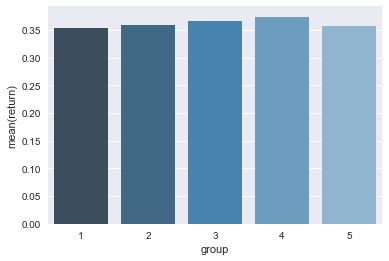

In [48]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [50]:
benchmark = "881001.WI"
data = w.wsd(benchmark, 'close', START_DATE, END_DATE)
ben_df = wind2df(data)
ben_df['return'] = ben_df['close'].pct_change()
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['beta'] = ben_df['return'].rolling(window=243).cov(df['return'].rolling(window=243)) / ben_df['return'].rolling(window=243).var()
    for ind in df.index[1:]:
        year = ind.year
        stock_df.loc[stock, "%d beta"%(year)] = df.loc[ind, "beta"]

In [57]:
ranks = get_ranks(stock_df, 10)

In [58]:
factors = ["beta"]
weights = [1]

In [59]:
group_df = get_group_return(stock_df, factors, weights, years, ranks)

In [60]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,1.788266,2.569420,-0.691054,1.711433,0.056704,-0.328593,0.040029,0.364063,0.818530,0.796622,-0.303523
2,0.626159,1.955227,-0.640240,1.075125,0.147232,-0.321391,0.087124,0.424426,0.328541,0.636610,-0.184638
3,0.748492,1.871093,-0.664274,1.215346,0.032613,-0.355166,-0.070813,0.169887,0.303647,0.918367,-0.139298
4,0.825117,1.864969,-0.573003,1.135454,0.199792,-0.384555,0.075062,0.265052,0.593380,0.599296,-0.130652
5,0.856919,1.541667,-0.660946,1.334340,0.052714,-0.214065,0.012367,-0.249624,0.589302,0.474770,-0.112816
6,0.530118,1.831517,-0.584802,1.171235,0.047763,-0.268788,0.039753,0.054559,0.372302,0.711892,-0.096366
7,0.804918,1.901228,-0.644603,0.945043,0.011597,-0.280114,-0.039647,0.167272,0.580658,0.129102,-0.121705
8,0.569227,1.395889,-0.519825,0.978523,-0.057941,-0.307688,0.091699,0.239148,0.378162,0.577922,-0.121526
9,1.075052,1.258208,-0.569960,0.728933,-0.005698,-0.248952,-0.014313,0.169074,0.299385,0.110608,-0.099187
10,1.068650,1.134427,-0.558273,1.059323,0.061332,-0.067594,0.143004,-0.127500,0.465630,0.145463,0.041255


In [65]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

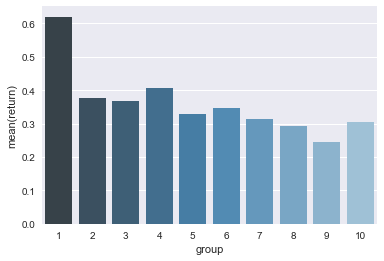

In [66]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [43]:
group_df.to_excel("%s/volatility.xlsx"%(DATA_DIR))